In [1]:
from PIL import Image
import requests
import io
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import pyocr

In [2]:
def openImg(url):
    pil_img = Image.open(io.BytesIO(requests.get(url).content))
    pil_img = pil_img.convert('RGB')
    np_img = np.array(pil_img)
    return np_img

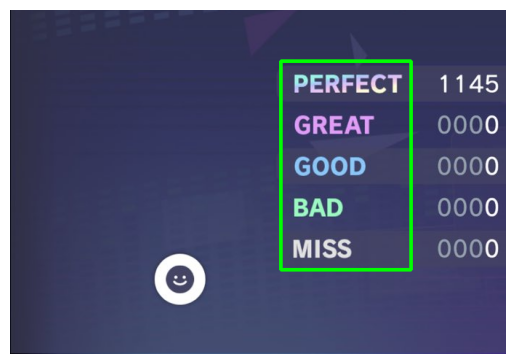

In [69]:
def searchPosition(templ_img, query_img, good_match_rate=0.30):
    # https://qiita.com/sitar-harmonics/items/41d54dbfc6c81b87b905
    
    # A-KAZE検出器の生成
    detector = cv2.AKAZE_create()
    templ_kp, templ_des = detector.detectAndCompute(templ_img, None)

    # 特徴量の検出と特徴量ベクトルの計算
    query_kp, query_des = detector.detectAndCompute(query_img, None)

    # マッチング
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # 特徴量ベクトル同士をマッチング
    matches = bf.match(query_des, templ_des)

    # 特徴量をマッチング状況に応じてソート
    matches = sorted(matches, key = lambda x:x.distance)
    good = matches[:int(len(matches) * good_match_rate)]

    # 位置計算
    src_pts = np.float32([templ_kp[m.trainIdx].pt for m in good])
    dst_pts = np.float32([query_kp[m.queryIdx].pt for m in good])
    Mx, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)

    # 画像４隅の角座標を取得
    th = templ_img.shape[0]
    tw = templ_img.shape[1]
    pts = np.array([[[0,0], [0,th-1],[tw-1,th-1],[tw-1,0]]], dtype=np.float32)
    dst = cv2.perspectiveTransform(pts,Mx)
    return  Mx, np.int32(dst)


from_img = cv2.cvtColor(cv2.imread('./template.png'), cv2.COLOR_BGR2RGB)
to_img = openImg("https://raw.githubusercontent.com/result-database/ocr-api-v3-notebook/main/wide1.jpg")
to_img = to_img[to_img.shape[0] // 2:to_img.shape[0], 0:to_img.shape[1] // 3]

Mx, dst = searchPosition(templ_img=from_img, query_img=to_img)

plt.imshow(cv2.polylines(to_img, [np.int32(dst)], True, (0, 255, 0), 3))
plt.axis('off')
plt.show()